In [1]:
import math
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## -----------------------------------------------------------------
## load expression data
## -----------------------------------------------------------------
countsFile = "../dataset/GSE67196_Petrucelli2015_ALS_genes.logRpm.tsv"
counts= pd.read_csv(
countsFile,
sep = "\t",
header = 0,
index_col = 0,
)

In [3]:
## -----------------------------------------------------------------
## load sample annotations
## -----------------------------------------------------------------
annotFile = "../dataset/gse67196_annot.mod.csv"
annot = pd.read_csv(annotFile, header=0, index_col=0)

In [4]:
## -----------------------------------------------------------------
## look at counts dataframe
## -----------------------------------------------------------------
counts.head()

,1_cereb,1_FCX,2_cereb,2_FCX,34_cereb,34_FCX,57_cereb,57_FCX,6_cereb,6_FCX,...,91_FCX,93_cereb,93_FCX,94_cereb,94_FCX,95_cereb,95_FCX,97_cereb,97_FCX,100_FCX
GeneID,,,,,,,,,,,,,,,,,,,,,
PHLPP2,5.909557,5.108482,6.069789,5.432788,4.402916,5.182626,5.570783,5.053061,4.901018,5.123821,...,4.986832,6.393348,5.752658,5.896011,5.106262,5.326388,5.217365,5.633764,5.324098,4.973132
PRKCB,6.738681,8.295125,6.950876,8.685235,6.750678,8.803370,6.242389,8.756242,6.090052,8.325762,...,8.910379,7.632890,9.286226,6.237865,8.673589,6.754022,8.376900,6.847478,9.192437,8.219855
RAB41,2.223819,2.598133,2.681769,2.311306,2.930419,2.616183,2.338327,2.192555,3.004395,2.407195,...,2.534554,1.885857,1.957711,2.087045,2.823969,2.250675,1.991774,2.556871,2.045452,2.508716
CST11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045336,0.000000,0.000000
APH1A,6.235894,6.356775,5.788656,5.967548,5.934979,5.948514,5.843478,6.070658,6.924903,6.646608,...,6.186662,6.117029,5.742801,6.735619,6.317319,6.700825,6.594392,6.205893,6.015323,6.792174


In [5]:
## -----------------------------------------------------------------
## look at sample annotations dataframe
## -----------------------------------------------------------------
annot.head()

,origin,tissue,genotype,age_of_death,preexisting_score
sample,,,,,
1_cereb,brain,tissue: Cerebellum,genotype: c9ALS,88,1.2
1_FCX,brain,tissue: Frontal Cortex,genotype: c9ALS,82,1.3
2_cereb,brain,tissue: Cerebellum,genotype: c9ALS,86,1.4
2_FCX,brain,tissue: Frontal Cortex,genotype: c9ALS,75,2.1
34_cereb,brain,tissue: Cerebellum,genotype: c9ALS,74,2.2


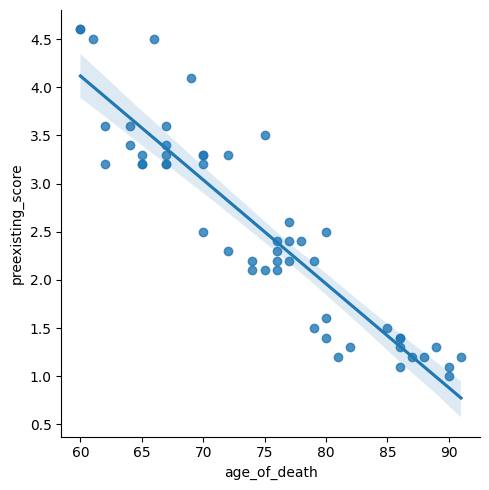

In [6]:
#Is there a relationship bdtween the age_of_death and preexisting_score?
annot.corr()
sns.lmplot(x='age_of_death',y='preexisting_score', data=annot)

In [7]:
print(annot['genotype'].value_counts())

genotype: sALS       20
genotype: Healthy    17
genotype: c9ALS      16
Name: genotype, dtype: int64


In [8]:
#Is there a relationship between the age_of_death and genotype?
#First convert the categorial variable to a coded variable
annot['genotype_coded']=annot['genotype'].replace(['genotype: sALS','genotype: Healthy','genotype: c9ALS'],[2,0,1])

In [9]:
#print(annot.head())
annot.corr()

,age_of_death,preexisting_score,genotype_coded
age_of_death,1.000000,-0.918809,-0.316874
preexisting_score,-0.918809,1.000000,0.300661
genotype_coded,-0.316874,0.300661,1.000000


In [10]:
counts.shape

(23293, 53)

In [11]:
highcountgenes=counts.sum(axis=1) >5
#print(highcountgenes)
countsSmall=counts[highcountgenes]
print(countsSmall.head())

         1_cereb     1_FCX   2_cereb     2_FCX  34_cereb    34_FCX  57_cereb  \
GeneID                                                                         
PHLPP2  5.909557  5.108482  6.069789  5.432788  4.402916  5.182626  5.570783   
PRKCB   6.738681  8.295125  6.950876  8.685235  6.750678  8.803370  6.242389   
RAB41   2.223819  2.598133  2.681769  2.311306  2.930419  2.616183  2.338327   
APH1A   6.235894  6.356775  5.788656  5.967548  5.934979  5.948514  5.843478   
USP27X  5.653730  3.828167  5.027248  4.242725  3.843327  3.652214  4.857387   

          57_FCX   6_cereb     6_FCX  ...    91_FCX  93_cereb    93_FCX  \
GeneID                                ...                                 
PHLPP2  5.053061  4.901018  5.123821  ...  4.986832  6.393348  5.752658   
PRKCB   8.756242  6.090052  8.325762  ...  8.910379  7.632890  9.286226   
RAB41   2.192555  3.004395  2.407195  ...  2.534554  1.885857  1.957711   
APH1A   6.070658  6.924903  6.646608  ...  6.186662  6.117029  5

In [12]:
#Select from the data frame, the samples pertaining to the conditions and brain regions of interest
#Frontal Cortex sALS vs Frontal Cortex Healthy
#Which samples meet the condition of genotype either sALS or Healthy and tissue Frontal Cortex
sALSFrontal=(annot['genotype'].str.contains('sALS')) & (annot['tissue'].str.contains('Frontal Cortex'))
sALSsamples=list(annot[sALSFrontal].index)
#print(sALSsamples)
healthyFrontal=(annot['genotype'].str.contains('Healthy')) & (annot['tissue'].str.contains('Frontal Cortex'))
healthysamples=list(annot[healthyFrontal].index)
#print(healthysamples)
allsamples=sALSsamples+healthysamples
print(allsamples)

['11_FCX', '12_FCX', '13_FCX', '14_FCX', '70_FCX', '71_FCX', '72_FCX', '73_FCX', '74_FCX', '75_FCX', '24_FCX', '86_FCX', '90_FCX', '91_FCX', '93_FCX', '94_FCX', '95_FCX', '97_FCX', '100_FCX']


In [13]:
#Subset of counts data frame with just my samples of interest
countsSmall=countsSmall[allsamples]
#What's different between counts and countsSmall?

In [14]:
print(countsSmall.head())

          11_FCX    12_FCX    13_FCX    14_FCX    70_FCX    71_FCX    72_FCX  \
GeneID                                                                         
PHLPP2  5.412886  6.117910  6.019199  5.739929  5.587916  5.703547  5.664724   
PRKCB   8.825089  9.856517  9.878497  9.422512  9.304770  9.362255  9.300896   
RAB41   2.169156  1.309016  1.650921  2.005832  1.944460  2.104034  1.812280   
APH1A   6.523547  5.951947  5.966451  5.996699  6.112546  6.006846  5.915296   
USP27X  4.019492  4.517402  4.505202  4.104330  4.469552  4.423845  4.510885   

          73_FCX    74_FCX    75_FCX    24_FCX    86_FCX    90_FCX    91_FCX  \
GeneID                                                                         
PHLPP2  5.047927  5.394200  5.938863  4.850808  5.530957  6.071428  4.986832   
PRKCB   8.423032  8.797191  9.742676  8.411517  9.356412  9.882987  8.910379   
RAB41   2.784141  2.442724  1.941847  2.172428  2.115264  1.987283  2.534554   
APH1A   6.577683  6.259478  5.985985  6

In [15]:
#Perform t-test on every gene and add these statistics to the countsSmall dataframe
t,p=scipy.stats.ttest_ind(countsSmall[sALSsamples],countsSmall[healthysamples],axis=1)
t=list(t)
p=list(p)
countsSmall['tstatistic']=t
countsSmall['pvalue']=p
print(countsSmall.head())

          11_FCX    12_FCX    13_FCX    14_FCX    70_FCX    71_FCX    72_FCX  \
GeneID                                                                         
PHLPP2  5.412886  6.117910  6.019199  5.739929  5.587916  5.703547  5.664724   
PRKCB   8.825089  9.856517  9.878497  9.422512  9.304770  9.362255  9.300896   
RAB41   2.169156  1.309016  1.650921  2.005832  1.944460  2.104034  1.812280   
APH1A   6.523547  5.951947  5.966451  5.996699  6.112546  6.006846  5.915296   
USP27X  4.019492  4.517402  4.505202  4.104330  4.469552  4.423845  4.510885   

          73_FCX    74_FCX    75_FCX  ...    86_FCX    90_FCX    91_FCX  \
GeneID                                ...                                 
PHLPP2  5.047927  5.394200  5.938863  ...  5.530957  6.071428  4.986832   
PRKCB   8.423032  8.797191  9.742676  ...  9.356412  9.882987  8.910379   
RAB41   2.784141  2.442724  1.941847  ...  2.115264  1.987283  2.534554   
APH1A   6.577683  6.259478  5.985985  ...  5.895258  5.963194  6

In [16]:
#Identify DEGs as genes with pvalue <=0.01
deg_boolean=countsSmall['pvalue']<=0.01
DEGs=countsSmall[deg_boolean]
DEGnames=countsSmall[deg_boolean].index

In [17]:
#How many DEGs do we have?
DEGs=DEGs.drop(['pvalue','tstatistic'],axis=1)
print(DEGs.head())

          11_FCX    12_FCX    13_FCX    14_FCX    70_FCX    71_FCX    72_FCX  \
GeneID                                                                         
HAGHL   4.255624  3.994180  4.306893  3.707614  4.512331  3.613067  4.314960   
PRKG1   3.166232  3.104292  3.221283  3.035618  2.819988  3.096676  2.925855   
EXOSC2  4.603915  4.604484  4.656829  4.695325  4.535141  4.492869  4.472664   
SCRT1   7.339961  6.996784  7.385175  6.956828  7.058793  7.086702  7.634915   
MTMR1   4.552026  4.632381  4.700550  4.611676  4.565004  4.780752  4.843823   

          73_FCX    74_FCX    75_FCX    24_FCX    86_FCX    90_FCX    91_FCX  \
GeneID                                                                         
HAGHL   4.838646  4.280516  4.251455  5.211054  4.830139  4.111250  5.471000   
PRKG1   3.000903  3.707111  3.208161  2.358070  2.548932  2.937130  2.758446   
EXOSC2  4.313468  4.475477  4.716637  4.185484  4.589991  4.397378  4.533779   
SCRT1   7.594566  7.589852  7.056927  7

In [18]:
print(annot['genotype'].unique())

['genotype: c9ALS' 'genotype: sALS' 'genotype: Healthy']


/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


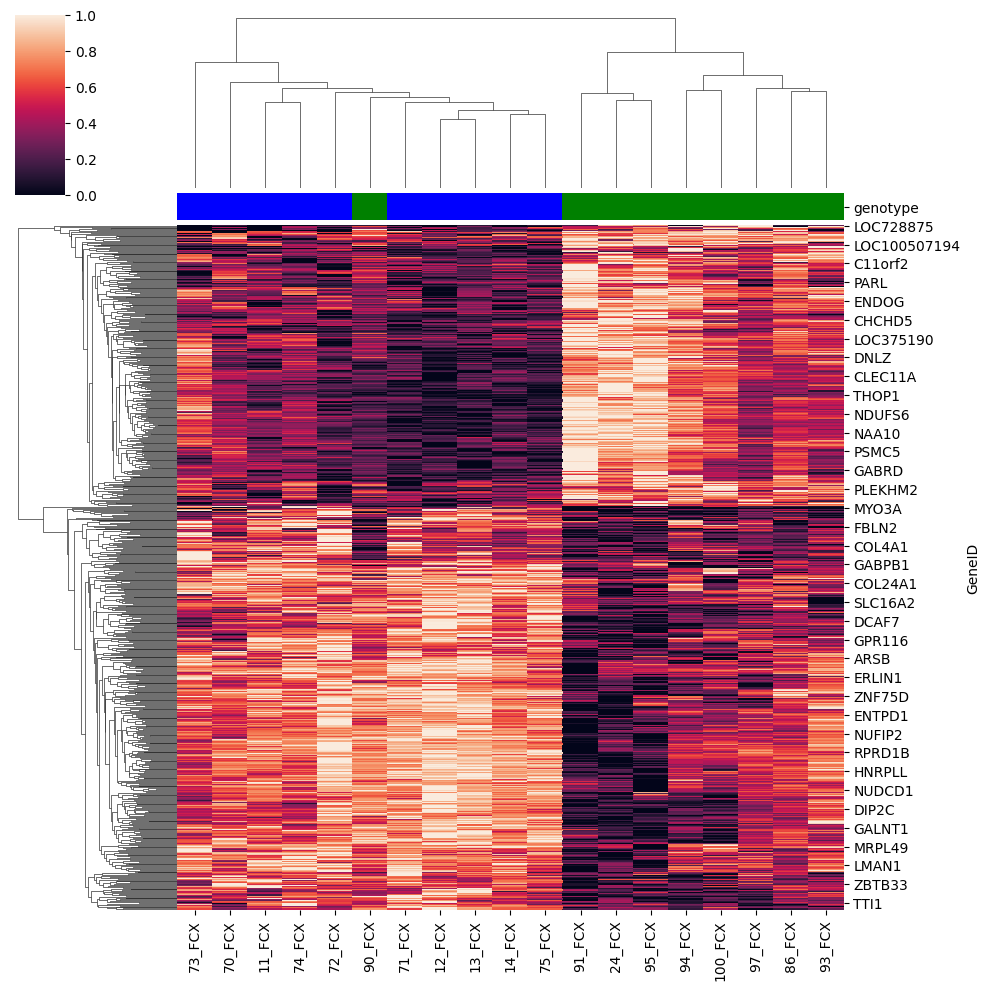

In [19]:
lut=dict(zip(annot['genotype'].unique(), "rbg"))
col_colors= annot['genotype'].map(lut)
#print(col_colors)
sns.clustermap(DEGs, standard_scale=0, col_colors=col_colors)